In [1]:
import pandas as pd
from acled_conflict_analysis import analysis
from acled_conflict_analysis import visuals
import ast
import json
import geopandas as gpd
from shapely.geometry import Point
# import dask_geopandas as gpd
# import dask.dataframe as dd

import glob

c:\WBG\Anaconda3\envs\data-goods\Lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Air Pollution in the West Bank and Gaza Strip

In [2]:
palestine = gpd.read_file('../../data/boundaries/pse_admbnda_adm1_pamop_20231019.shp')
west_bank = palestine[palestine['ADM1_EN']=='West Bank']
gaza = palestine[palestine['ADM1_EN']=='Gaza Strip']

In [ ]:
#west_bank.to_file('../../data/boundaries/west_bank.shp')

In [3]:
import h3
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

def polygon_to_h3(polygon, resolution):
    """Convert a polygon to H3 indices."""
    h3_indices = h3.polyfill(polygon.__geo_interface__, resolution, geo_json_conformant=True)
    return h3_indices

def h3_to_polygon(h3_index):
    """Convert an H3 index to a polygon."""
    boundary = h3.h3_to_geo_boundary(h3_index, geo_json=True)
    return Polygon(boundary)

def convert_to_h3_gdf(geo_df, resolution):
    """Convert a GeoDataFrame to H3 indices and return a new GeoDataFrame with H3 indices and polygons."""
    h3_indices = set()
    for geom in geo_df.geometry:
        if isinstance(geom, Polygon):
            h3_indices.update(polygon_to_h3(geom, resolution))
        elif isinstance(geom, MultiPolygon):
            for poly in geom:
                h3_indices.update(polygon_to_h3(poly, resolution))
    
    h3_polygons = [h3_to_polygon(h3_index) for h3_index in h3_indices]
    h3_gdf = gpd.GeoDataFrame({'h3_index': list(h3_indices), 'geometry': h3_polygons}, crs=geo_df.crs)
    return h3_gdf

# Convert the Gaza polygon to H3 grids
#west_bank_h3_gdf = convert_to_h3_gdf(west_bank, resolution=7)


In [132]:
def get_annual_baseline(df, group_column='ADM1_EN', baseline_year='PY'):
    df = df.copy()
    df['year'] = df['event_date'].dt.year

    if isinstance(baseline_year, int):  # Fixed baseline year case
        # Compute annual baseline NO2 for the specified baseline year
        baseline_df = (
            df[df['year'] == baseline_year]
            .groupby(group_column)['NO2']
            .mean()
            .reset_index()
            .rename(columns={'NO2': 'baseline_NO2'})
        )

        # Merge the fixed-year baseline into the original DataFrame
        df = df.merge(baseline_df, on=[group_column], how='left')

    elif baseline_year == 'PY':  # Previous year case
        df['baseline_NO2'] = None  # Initialize column for baseline NO2 values

        # Get all unique years in the dataset
        years = sorted(df['year'].unique())

        # Iterate through each year (starting from the second year in the dataset)
        for year in years[1:]:  # Ensure there's a previous year
            # Compute the previous year's annual baseline
            baseline_df = (
                df[df['year'] == year - 1]  # Get the previous year's data
                .groupby(group_column)['NO2']
                .mean()
                .rename('baseline_NO2')
            )

            # Use .map() to assign the previous year's NO2 values correctly
            df.loc[df['year'] == year, 'baseline_NO2'] = df.loc[df['year'] == year, group_column].map(baseline_df)

    else:
        raise ValueError("Invalid baseline_year argument. Use an integer for a fixed year or 'PY' for previous year.")

    # Compute the annual percentage change
    df['percent_change_NO2'] = ((df['NO2'] - df['baseline_NO2']) / df['baseline_NO2']) * 100

    return df


In [160]:
def get_monthly_baseline(df, group_column, baseline_year='PY'):
    df = df.copy()
    df['year'] = df['event_date'].dt.year
    df['month'] = df['event_date'].dt.month

    if isinstance(baseline_year, int):  # Fixed baseline year case
        # Compute monthly NO2 baseline for the specified baseline year
        baseline_df = (
            df[df['year'] == baseline_year]
            .groupby([group_column, 'month'])['NO2']
            .mean()
            .reset_index()
            .rename(columns={'NO2': 'baseline_NO2'})
        )

        # Merge the fixed-year baseline into the original DataFrame
        df = df.merge(baseline_df, on=[group_column, 'month'], how='left')

    elif baseline_year == 'PY':  # Previous year case
        df['baseline_NO2'] = None  # Initialize column for baseline NO2 values

        # Get all unique years in the dataset
        years = sorted(df['year'].unique())

        # Iterate through each year (starting from the second year in the dataset)
        for year in years[1:]:  # Ensure there's a previous year
            # Compute the previous year's monthly baseline
            baseline_df = (
                df[df['year'] == year - 1]  # Get the previous year's data
                .groupby([group_column, 'month'])['NO2']
                .mean()
                .rename('baseline_NO2')
            )

            # Use .map() to assign the previous year's NO2 values correctly
            df.loc[df['year'] == year, 'baseline_NO2'] = df.loc[df['year'] == year, [group_column, 'month']].apply(
                lambda row: baseline_df.get((row[group_column], row['month'])), axis=1
            )

    else:
        raise ValueError("Invalid baseline_year argument. Use an integer for a fixed year or 'PY' for previous year.")

    # Compute the monthly percentage change
    df['percent_change_NO2'] = ((df['NO2'] - df['baseline_NO2']) / df['baseline_NO2']) * 100

    return df


In [6]:

def clean_air_pollution(df):
    if 'system:index' in df.columns:
        df.drop(columns='system:index', inplace=True)

    if '.geo' in df.columns:
        df['.geo'] = df['.geo'].apply(lambda x: json.loads(x))
        df['coordinates'] = df['.geo'].apply(lambda x: x['coordinates'])
        df.drop(columns=['.geo'], inplace=True)
        df['geometry'] = df.apply(lambda row: Point(row['coordinates']) if isinstance(row['coordinates'], list) and len(row['coordinates']) >= 2 else None, axis=1)
        df['longitude'] = df['coordinates'].apply(lambda x: x[0])
        df['latitude'] = df['coordinates'].apply(lambda x: x[1])

    
    if 'admin0Name' in df.columns:
        df.rename(columns={'admin0Name':'ADM0_EN', 'admin1Name':'ADM1_EN', 'admin2Name':'ADM2_EN'}, inplace=True)
        
    #df = df[['ADM0_EN', 'ADM1_EN', 'date','mean']]

    df.rename(columns={'date':'event_date', 'mean':'mean_NO2', 'NO2_column_number_density':'NO2', 'startMonth':'event_date'}, inplace=True)
    df['event_date'] = pd.to_datetime(df['event_date'])

    

In [ ]:
#air_pollution = pd.read_csv('../../data/air-pollution/no2_west_bank_20240511.csv')

In [7]:
 # Check if the file is greater than 1KB
import pandas as pd
import glob
import os

# Define the path to the air-pollution folder
path = '../../data/air-pollution/'

# Use glob to find all files starting with the number 2
all_files = glob.glob(path + '2*.csv')

# Initialize an empty list to store DataFrames
dfs = []

# Loop through the list of files and read each one into a DataFrame
for file in all_files:
    if os.path.getsize(file) > 1024:  # Check if the file is not empty
        df = pd.read_csv(file)
        if df.empty:
            continue
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
if dfs:
    air_pollution = pd.concat(dfs, ignore_index=True)
else:
    air_pollution = pd.DataFrame()  # Create an empty DataFrame if no valid files are found

In [8]:

# Ensure that the input to ast.literal_eval is a valid string representation of a Python literal
clean_air_pollution(air_pollution)


c:\WBG\Anaconda3\envs\data-goods\Lib\site-packages\pandas\core\dtypes\cast.py:131: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [9]:
roads = gpd.read_file('../../data/poi/roads_oPt/Road_network_oPt.shp')
roads = roads[roads['Region']=='West Bank']

In [10]:
west_bank = gpd.read_file('../../data/boundaries/west_bank.shp')
west_bank_adm2 = gpd.read_file('../../data/boundaries/pse_admbnda_adm2_pamop_20231019.shp')
west_bank_adm2 = west_bank_adm2[west_bank_adm2['ADM1_EN']=='West Bank']

In [31]:
roads.to_crs('EPSG:4326', inplace=True)

In [32]:
roads_of_interest = gpd.read_file('../../data/poi/roads_of_interest.geojson')
crossings_of_interest = gpd.read_file('../../data/poi/crossings_of_interest.geojson')
crossings_of_interest = roads.sjoin(crossings_of_interest)

In [33]:
# Concatenate the GeoDataFrames
roads_of_interest = pd.concat([roads[roads['Class']=='Main']])

In [13]:
roads_of_interest.to_file('../../data/poi/roads_of_interest.shp')

In [232]:
#points = air_pollution[['longitude', 'latitude']].drop_duplicates()

#points = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['longitude'], points['latitude']), crs='EPSG:4326')


In [15]:
# from shapely.geometry import Point, Polygon

# # Step 1: Reproject to a local UTM projection to work in meters
# points_utm = points.to_crs(epsg=32633)  # Adjust UTM zone based on your region

# # Step 2: Create 1.1 km x 1.1 km boxes around each center point
# cell_size = 5000  # 1.1 km in meters
# half_size = cell_size / 2

# def create_box_around_point(point, half_size):
#     """Create a 1.1 km x 1.1 km box (Polygon) around a point."""
#     x, y = point.x, point.y
#     return Polygon([(x - half_size, y - half_size), 
#                     (x + half_size, y - half_size), 
#                     (x + half_size, y + half_size), 
#                     (x - half_size, y + half_size)])

# # Apply the function to create boxes around each point
# boxes = points_utm['geometry'].apply(lambda point: create_box_around_point(point, half_size))

# # Step 3: Create a new GeoDataFrame with the boxes
# boxes_gdf = gpd.GeoDataFrame(geometry=boxes, crs=points_utm.crs)

# # Step 4: Reproject back to WGS84 if needed (optional)
# boxes_wgs84 = boxes_gdf.to_crs(epsg=4326)

In [16]:
#boxes_wgs84.to_file('../../data/air-pollution/west_bank_boxes.shp')
boxes_wgs84 = gpd.read_file('../../data/air-pollution/west_bank_boxes.shp')

In [17]:
boxes_wgs84 = boxes_wgs84.reset_index()
boxes_wgs84.rename(columns ={'index':'box_id'}, inplace=True)

In [26]:
air_pollution = gpd.GeoDataFrame(air_pollution, geometry = 'geometry', crs='EPSG:4326')
air_pollution = boxes_wgs84.sjoin(air_pollution)
air_pollution.drop(columns=['index_right', 'coordinates'], inplace=True)

In [34]:
#roads_of_interest.drop(columns='index_right', inplace=True)
crossings_of_interest.drop(columns='index_right', inplace=True)

len(boxes_wgs84.sjoin(crossings_of_interest)['box_id'].unique())/max(boxes_wgs84['box_id'])

0.04316546762589928

In [35]:
#crossings_of_interest.to_crs(epsg=4326, inplace=True)
boxes_of_interest = list(boxes_wgs84.sjoin(roads_of_interest)['box_id'].unique())
crossing_boxes_of_interest = list(boxes_wgs84.sjoin(crossings_of_interest)['box_id'].unique())
highways_of_interest = list(boxes_wgs84.sjoin(roads[roads['Class']=='Main'])['box_id'].unique())

In [57]:
air_pollution_monthly = air_pollution.groupby(['box_id', pd.Grouper(key='event_date', freq='MS')])['NO2'].mean().reset_index()
air_pollution_annual = air_pollution.groupby(['box_id', pd.Grouper(key='event_date', freq='YS')])['NO2'].mean().reset_index()

In [52]:
air_pollution_monthly_westbank = air_pollution.groupby([pd.Grouper(key='event_date', freq='MS')])['NO2'].mean().reset_index()
air_pollution_annual_westbank = air_pollution.groupby([pd.Grouper(key='event_date', freq='YS')])['NO2'].mean().reset_index()

In [53]:
air_pollution_monthly_westbank['ADM1_EN'] = 'West Bank'
air_pollution_annual_westbank['ADM1_EN'] = 'West Bank'

**Average Annual Air Pollution has fallen in 2024 compared to 2023 by 8.2%.**

In [47]:
ap2023 = air_pollution_annual_westbank[air_pollution_annual_westbank['event_date']=='2023-01-01']['NO2'].iloc[0]
ap2024 = air_pollution_annual_westbank[air_pollution_annual_westbank['event_date']=='2024-01-01']['NO2'].iloc[0]

pc = 100*(ap2024-ap2023)/ap2023
print(pc)

-8.21123420503145


In [39]:
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel
import bokeh
bokeh.core.validation.silence(MISSING_RENDERERS, True)


output_notebook()

# Grouping and calculating the monthly mean by aoi
df = air_pollution_monthly_westbank

# Group by year and calculate the yearly average NO2
yearly_avg = air_pollution_annual_westbank

tabs = []

for measure in ['NO2']:
    # Get the line plot for monthly NO2
    p = visuals.get_line_plot(
                df,
                "Monthly National Air Pollution",
                "Source: Sentinel 5-P extracted from Google Earth Engine",
                subtitle = "",
                category = 'ADM1_EN',
                measure=measure
    )

    # # Add a line for yearly averages
    # # Assuming you have a way to map the 'year' values to a datetime format for the x-axis in the plot
    p.children[1].line(x=pd.to_datetime(air_pollution_annual_westbank['event_date'].dt.year, format='%Y'), y=air_pollution_annual_westbank[measure], 
        line_width=2, color='red', legend_label=f'Yearly Average {measure}')
    
    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with both the monthly and yearly average lines
tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)


Loading BokehJS ...

In [61]:
air_pollution_monthly = boxes_wgs84.merge(air_pollution_monthly)
air_pollution_annual = boxes_wgs84.merge(air_pollution_annual)

In [126]:
air_pollution_monthly_adm2 = west_bank_adm2.sjoin(air_pollution_monthly)
air_pollution_monthly_adm2 = air_pollution_monthly_adm2.groupby(['ADM2_EN', 'event_date'])['NO2'].mean().reset_index()

In [124]:
air_pollution_annual_adm2 = west_bank_adm2.sjoin(air_pollution_annual)
air_pollution_annual_adm2 = air_pollution_annual_adm2.groupby(['ADM2_EN', 'event_date'])['NO2'].mean().reset_index()

In [125]:
air_pollution_annual_adm2 = get_annual_baseline(air_pollution_annual_adm2, baseline_year=2023, group_column='ADM2_EN')

In [127]:
air_pollution_monthly_adm2 = get_monthly_baseline(air_pollution_monthly_adm2, baseline_year=2023, group_column='ADM2_EN')

**Tulkarm saw the highest drop in annual average air pollution in 2024 compared to 2023. Followed by Salfit, Qalqiya, Nablus and Jenin.** As of November 2024, Ramallah (142), Hebron (129) and Nablus (128) governorates have the highest number of obstacles to movement.([UNOCHA 2024](https://www.unocha.org/publications/map/occupied-palestinian-territory/west-bank-access-restrictions-november-2024)). Of these three governorates, Nablus saw higher reduction in air pollution annually. 

In [243]:
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel
bokeh.core.validation.silence(MISSING_RENDERERS, True)


output_notebook()

# Grouping and calculating the monthly mean by aoi
df = air_pollution_annual_adm2


tabs = []
labels = ['Annual Governorate Air Pollution', 'Percent Change in Governorate Air Pollution Compared to Previous Year']
for idx, measure in enumerate(['NO2', 'percent_change_NO2']):
    # Get the line plot for monthly NO2
    p = visuals.get_line_plot(
                df,
                labels[idx],
                "Source: Sentinel 5-P extracted from Google Earth Engine",
                subtitle = "",
                category = 'ADM2_EN',
                measure=measure
    )

    # # Add a line for yearly averages
    # # Assuming you have a way to map the 'year' values to a datetime format for the x-axis in the plot
    # p.children[1].line(x=pd.to_datetime(air_pollution_annual_adm1['event_date'].dt.year, format='%Y'), y=air_pollution_annual_adm1[measure], 
    #     line_width=2, color='red', legend_label=f'Yearly Average {measure}')
    
    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with both the monthly and yearly average lines
tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)


Loading BokehJS ...

**In January 2024, Hebron's Old City was closed ([PCHR](https://reliefweb.int/report/occupied-palestinian-territory/field-report-accelerated-settlement-activities-hebron-enar#:~:text=The%20Palestinian%20Centre%20for%20Human,Settlement%20Outposts)). In the same month, the air pollution dropped significantly compared to January of 2023 by more than 20%.**

In [245]:
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.io import output_notebook, show
from bokeh.models import Span
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs, TabPanel
bokeh.core.validation.silence(MISSING_RENDERERS, True)


output_notebook()

# Grouping and calculating the monthly mean by aoi
df = air_pollution_monthly_adm2

# Group by year and calculate the yearly average NO2
df['year'] = pd.DatetimeIndex(df['event_date']).year

tabs = []
labels = ['Monthly Governorate Air Pollution', 'Percent Change in Monthly Governorate Air Pollution Compared to Previous Year']

for idx, measure in enumerate(['NO2', 'percent_change_NO2']):
    # Get the line plot for monthly NO2
    p = visuals.get_line_plot(
                df,
                labels[idx],
                "Source: Sentinel 5-P extracted from Google Earth Engine",
                subtitle = "",
                category = 'ADM2_EN',
                measure=measure
    )

    # # Add a line for yearly averages
    # # Assuming you have a way to map the 'year' values to a datetime format for the x-axis in the plot
    # p.children[1].line(x=pd.to_datetime(air_pollution_annual_adm1['event_date'].dt.year, format='%Y'), y=air_pollution_annual_adm1[measure], 
    #     line_width=2, color='red', legend_label=f'Yearly Average {measure}')
    
    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with both the monthly and yearly average lines
tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)


Loading BokehJS ...

In [265]:
air_pollution_monthly['ADM1_EN'] = 'West Bank'

In [72]:
# from bokeh.plotting import figure, show, output_notebook
# from bokeh.models import ColumnDataSource
# from bokeh.palettes import Category10
# import pandas as pd

# # Enable Bokeh in Jupyter Notebook
# output_notebook()

# # Prepare data
# df = air_pollution_monthly.copy()

# # Aggregate NO2 levels by month and administrative region
# df = df.groupby(['ADM1_EN', 'event_date'])['NO2'].mean().reset_index()
# df['year'] = df['event_date'].dt.year.astype(str)  # Convert year to string for labeling
# df['month'] = df['event_date'].dt.month  # Extract month as an integer

# # Create a Bokeh figure
# p = figure(
#     title=f"Monthly Air Pollution in {df['ADM1_EN'].unique()[0]}",
#     x_axis_label="Month",
#     y_axis_label="NO2 Level",
#     x_range=(1, 12),
#     width=800,  # Use `width` instead of `plot_width`
#     height=500  # Use `height` instead of `plot_height`
# )

# # Define a color palette for years
# colors = Category10[10]  # Up to 10 unique colors

# # Loop through each year and plot NO2 levels by month
# for i, year in enumerate(sorted(df['year'].unique())):
#     yearly_data = df[df['year'] == year]
    
#     source = ColumnDataSource(data={
#         "month": yearly_data['month'],
#         "NO2": yearly_data['NO2'],
#     })

#     p.line(
#         "month",
#         "NO2",
#         source=source,
#         line_width=2,
#         color=colors[i % len(colors)],
#         legend_label=str(year)
#     )
    

# # Format x-axis to show month names
# p.xaxis.ticker = list(range(1, 13))
# p.xaxis.major_label_overrides = {
#     1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr",
#     5: "May", 6: "Jun", 7: "Jul", 8: "Aug",
#     9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
# }

# p.legend.title = "Year"
# p.legend.location = "top_left"
# p.legend.click_policy = "hide"  # Allows toggling lines on/off
# p.legend.orientation = "horizontal" 

# # Show plot
# show(p)


In [ ]:
air_pollution_annual_adm2 = air_pollution_monthly_adm2.groupby([pd.Grouper(key='event_date', freq='YS'), 'ADM2_EN'])['NO2'].mean().reset_index()
air_pollution_annual_adm2 = get_annual_baseline(air_pollution_annual_adm2, baseline_year='PY', group_column='ADM2_EN')

**Air Pollution Levels fell in the entire region in 2024.** There is an uptick in pollution post COVID-19 in 2021 (similar to a global trend), which quickly fell. 

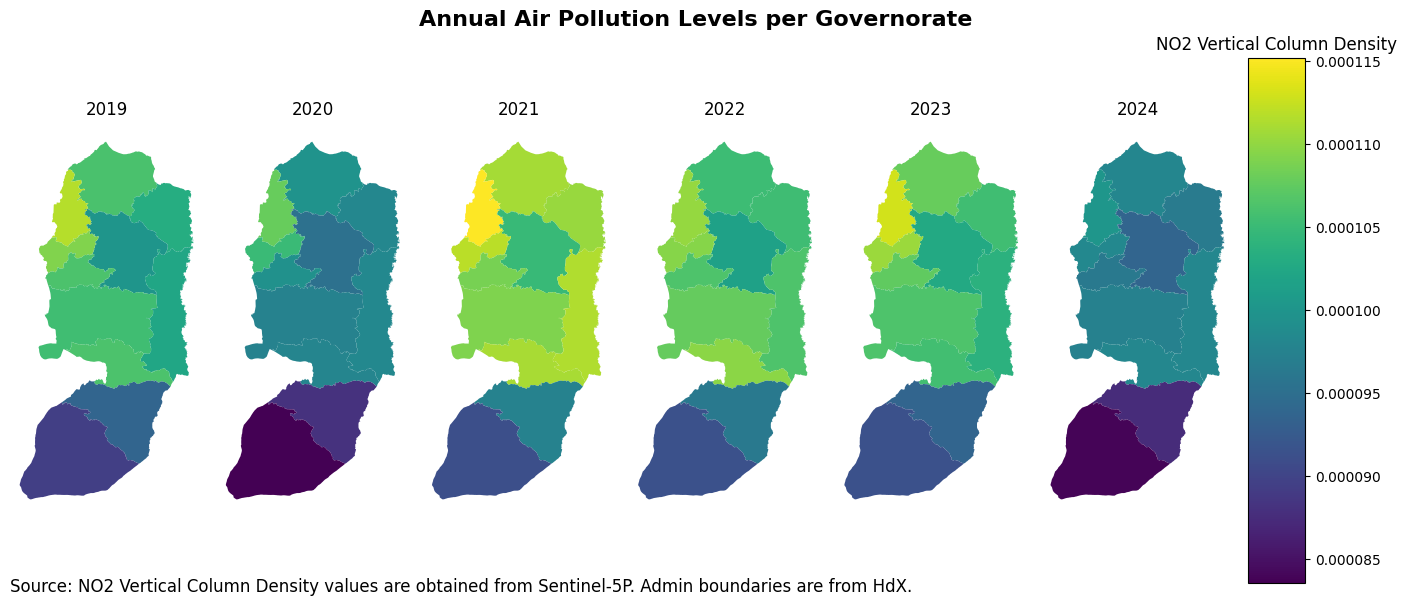

In [196]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# List of years you want to plot
years = [2019, 2020, 2021, 2022, 2023, 2024]  # You can extend this to more years if needed

# Create a 1x7 grid (6 plots + 1 for the legend)
fig, ax = plt.subplots(1, 7, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1, 0.3]})

# Flatten the axes array to make it easier to index
ax = ax.flatten()

vmin = air_pollution_annual_adm2['NO2'].min()
vmax = air_pollution_annual_adm2['NO2'].max()
cmap = 'viridis'  # Define colormap

# Loop through each year and create a plot
for i, year in enumerate(years):
    
    # Create the start and end date for each year dynamically
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    # Filter and group the data by latitude and longitude for the given year
    df = air_pollution_annual_adm2[
        (air_pollution_annual_adm2['event_date'] >= start_date) & 
        (air_pollution_annual_adm2['event_date'] <= end_date)
    ].groupby(['ADM2_EN'])['NO2'].mean().reset_index()

    # Convert to GeoDataFrame and plot for each year
    gdf = west_bank_adm2[['ADM2_EN', 'geometry']].merge(df)
    im = gdf.plot(column='NO2', ax=ax[i], cmap=cmap, vmin=vmin, vmax=vmax, legend=False)

    # Set the title for each subplot
    ax[i].set_title(f'{year}')
    
    # Remove the spines, ticks, and grid for a clean look
    ax[i].set_xticks([]); ax[i].set_yticks([]); 
    for spine in ax[i].spines.values():
        spine.set_visible(False)
    ax[i].grid(False)

# Add the colorbar (legend) in the last subplot
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array for the colorbar

cbar = fig.colorbar(sm, cax=ax[-1])  
ax[-1].set_title("NO2 Vertical Column Density")

# Automatically adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.suptitle('Annual Air Pollution Levels per Governorate', fontsize=16, fontweight='bold')


# Add a footer text at the bottom
plt.figtext(0.01, 0.01, "Source: NO2 Vertical Column Density values are obtained from Sentinel-5P. Admin boundaries are from HdX.", 
            ha="left", fontsize=12)


# Show the plot
plt.show()


In [156]:
air_pollution_annual_adm2['percent_change_NO2'] = air_pollution_annual_adm2['percent_change_NO2'].astype('float64')

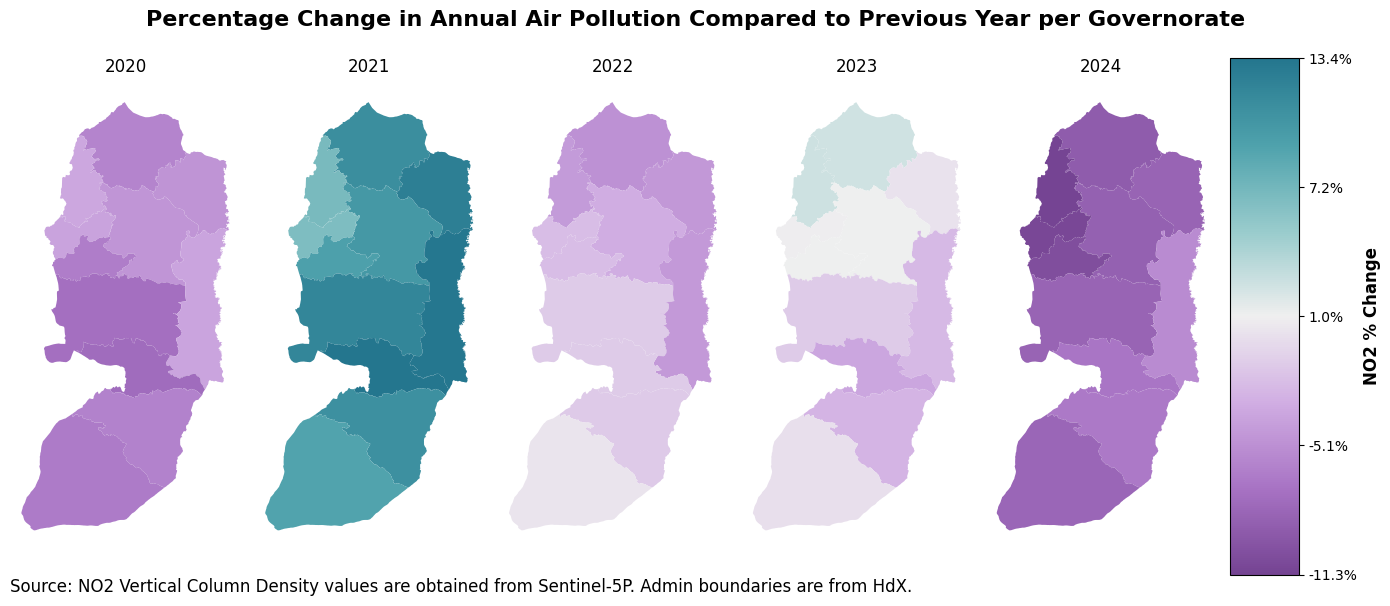

In [237]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define the custom colors
colors = ["#754493", "#A873C4", "#D1AEE3", "#EFEFEF", "#98CBCC", "#4EA2AC", "#24768E"]


# Create the custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# List of years you want to plot
years = [2020, 2021, 2022, 2023, 2024]  # You can extend this to more years if needed

# Create a figure with 6 subplots (5 maps + 1 for the legend)
fig, ax = plt.subplots(1, 6, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 0.3]})

# Flatten the axes array for easier indexing
ax = ax.flatten()

# Get min and max for normalization
vmin = air_pollution_annual_adm2['percent_change_NO2'].min()
vmax = air_pollution_annual_adm2['percent_change_NO2'].max()

# Loop through each year and create a plot
for i, year in enumerate(years):
    
    # Create the start and end date for each year dynamically
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    # Filter and group the data by latitude and longitude for the given year
    df = air_pollution_annual_adm2[
        (air_pollution_annual_adm2['event_date'] >= start_date) & 
        (air_pollution_annual_adm2['event_date'] <= end_date)
    ][['ADM2_EN', 'percent_change_NO2']]  # Ensure correct columns are selected

    df['percent_change_NO2'] = df['percent_change_NO2'].astype('float64')

    # Merge with spatial data and plot for each year
    gdf = west_bank_adm2.merge(df, on='ADM2_EN', how='left')
    im = gdf.plot(column='percent_change_NO2', ax=ax[i], cmap=custom_cmap, vmin=vmin, vmax=vmax)

    # Set the title for each subplot
    ax[i].set_title(f'{year}')
    
    # Remove spines, ticks, and grid for a clean look
    ax[i].set_xticks([]); ax[i].set_yticks([]); 
    for spine in ax[i].spines.values():
        spine.set_visible(False)
    ax[i].grid(False)

# Add the colorbar (legend) in the last subplot
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Empty array for the colorbar

# Create the colorbar and set percentage labels
cbar = fig.colorbar(sm, cax=ax[-1])
cbar.set_label("NO2 % Change", fontsize=12, fontweight="bold")

# Generate percentage-based tick labels
ticks = np.linspace(vmin, vmax, num=5)  # Define tick positions
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.1f}%" for t in ticks])  # Format as percentages

# Adjust the layout so the plots don't overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.suptitle('Percentage Change in Annual Air Pollution Compared to Previous Year per Governorate', 
             fontsize=16, fontweight='bold')

# Add a footer text at the bottom
plt.figtext(0.01, 0.01, "Source: NO2 Vertical Column Density values are obtained from Sentinel-5P. Admin boundaries are from HdX.", 
            ha="left", fontsize=12)

# Show the plot
plt.show()


In [162]:
air_pollution_monthly_adm2 = get_monthly_baseline(air_pollution_monthly_adm2, baseline_year='PY', group_column='ADM2_EN')

In [241]:
import matplotlib.pyplot as plt

# List of months you want to plot

years = [2022, 2023,2024]

df1 = west_bank_adm2[['ADM2_EN', 'geometry']].merge(air_pollution_monthly_adm2)

# Loop through each year and create a plot
for year in years:

    months = [f'{year}-{month:02d}-01' for month in range(1, 13)]
    # Create a 3x4 grid for the plots
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))

    # Flatten the axes array to make it easier to index
    ax = axs.flatten()

    vmin = df1['NO2'].min()
    vmax = df1['NO2'].max()

    # Loop through each month and create a plot in a 3x4 grid
    for i, month in enumerate(months):
        # Filter the data for the given month
        df = df1[df1['event_date'] == month]
        
        # Drop rows with NaN or infinite values
        df = df.replace([float('inf'), -float('inf')], float('nan')).dropna(subset=['NO2'])
        
        # Convert to GeoDataFrame and plot for each month
        df.plot(column='NO2', ax=ax[i], cmap='viridis', 
                                         vmin=vmin, vmax=vmax, legend=(i == 11))

        # Set the title for each subplot
        ax[i].set_title(f'NO2 in {month[:7]}')
        
        # Remove the spines, ticks, and grid for a clean look
        ax[i].set_xticks([]); ax[i].set_yticks([]); 
        for spine in ax[i].spines.values():
            spine.set_visible(False)
        ax[i].grid(False)

    # Automatically adjust the layout so the plots don't overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle(f'Monthly Air Pollution Levels in {year}')

    # Save the plot
    plt.savefig(f'../../docs/images/air_pollution_{year}.png')
    plt.close(fig)


C:\Users\wb588851\AppData\Local\Temp\ipykernel_4216\2782737330.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace([float('inf'), -float('inf')], float('nan')).dropna(subset=['NO2'])
C:\Users\wb588851\AppData\Local\Temp\ipykernel_4216\2782737330.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace([float('inf'), -float('inf')], float('nan')).dropna(subset=['NO2'])
C:\Users\wb588851\AppData\Local\Temp\ipykernel_4216\2782737330.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and

In [240]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the custom colors
colors = ["#754493", "#A873C4", "#D1AEE3", "#EFEFEF", "#98CBCC", "#4EA2AC", "#24768E"]


# Create the custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# List of years to plot
years = [2023, 2024]

# Merge spatial data with air pollution data
df1 = west_bank_adm2[['ADM2_EN', 'geometry']].merge(air_pollution_monthly_adm2)
df1 = df1[(df1['event_date']>='2023-01-01')&(df1['event_date']<='2024-12-01')]

df1['percent_change_NO2'] = df1['percent_change_NO2'].astype('float64')

# Get the min and max values across **all years and months**
vmin = df1['percent_change_NO2'].min()
vmax = df1['percent_change_NO2'].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Ensure consistent scaling

# Loop through each year and create a plot
for year in years:

    months = [f'{year}-{month:02d}-01' for month in range(1, 13)]
    
    # Create a 3x4 grid for the plots
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))

    # Flatten the axes array to make it easier to index
    ax = axs.flatten()

    # Loop through each month and create a plot in a 3x4 grid
    for i, month in enumerate(months):
        # Filter the data for the given month
        df = df1[df1['event_date'] == month]
        
        # Convert to GeoDataFrame and plot for each month
        df.plot(column='percent_change_NO2', ax=ax[i], cmap=custom_cmap, 
                     norm=norm, vmin=vmin, vmax=vmax)  # Ensure same vmin/vmax everywhere

        # Set the title for each subplot
        ax[i].set_title(f'NO2 in {month[:7]}')
        
        # Remove the spines, ticks, and grid for a clean look
        ax[i].set_xticks([]); ax[i].set_yticks([]); 
        for spine in ax[i].spines.values():
            spine.set_visible(False)
        ax[i].grid(False)

    # Add a single colorbar for the entire figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Define colorbar position
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label("NO2 % Change", fontsize=12, fontweight="bold")

    tick_values = np.linspace(vmin, vmax, num=6)  # Set evenly spaced tick labels
    cbar.set_ticks(tick_values)
    cbar.set_ticklabels([f"{t:.1f}%" for t in tick_values])  # Format as percentage

    # Set the overall title
    plt.suptitle(f'Monthly Percentage Change in Air Pollution Levels in {year} Compared to Previous Year', 
                 fontsize=14, fontweight="bold")

    #plt.show()
    #Save the plot
    plt.savefig(f'../../docs/images/air_pollution_pc{year}.png', dpi=300)
    plt.close(fig)


**Absolute values of NO2 vertical column density in 2024 were lesser than in 2023. However, there is an uptick in pollution in December 2024**

::::{tab-set}

:::{tab-item} 2022
![air_pollution_2022.png](../../docs/images/air_pollution_2022.png)
:::

:::{tab-item} 2023
![air_pollution_2023.png](../../docs/images/air_pollution_2023.png)
:::

:::{tab-item} 2024
![air_pollution_2024.png](../../docs/images/air_pollution_2024.png)
:::
::::

**Looking at percentage change in NO2 compared to previous years, allows us to see that January 2024 saw a significant drop in pollution.** This decline is also seen in December 2023 and October 2023. Although December 2024 shows a significant reduction in pollution compared to December 2023, this could be because 2023 December had particularly lower levels of pollution. From the above images, it can be seen that in December 2024 some governorates saw higher air pollution than December 2022 (Bethlehem, Jenin,Salfit, Tulkarm ) while others saw an increase (Jenin, Jericho,Jerusalem,Nablus,Ramallah, Tubas )

::::{tab-set}
:::{tab-item} 2023
![air_pollution_2023.png](../../docs/images/air_pollution_pc2023.png)
:::

:::{tab-item} 2024
![air_pollution_2024.png](../../docs/images/air_pollution_pc2024.png)
:::
::::

In [161]:
# from bokeh.plotting import figure, show, output_notebook
# from bokeh.models import ColumnDataSource, Panel, Tabs
# from bokeh.palettes import Category10
# import pandas as pd

# # Enable Bokeh in Jupyter Notebook
# output_notebook()

# # Define three different DataFrames for the tabs
# df1 = air_pollution_weekly[air_pollution_weekly['box_id'].isin(crossing_boxes_of_interest)].copy()
# df2 = air_pollution_weekly[air_pollution_weekly['box_id'].isin(boxes_of_interest)].copy()
# df3 = air_pollution_weekly.copy()

# dataframes = {"Crossing Areas": df1, "Main Roads": df2, "All": df3}

# global_y_max = 0.00015

# tabs = []

# for section_name, df in dataframes.items():
#     # Aggregate NO2 levels by week and administrative region
#     df = df.groupby(['ADM1_EN', 'event_date'])['NO2'].mean().reset_index()
#     df['year'] = df['event_date'].dt.year.astype(str)  # Convert year to string for labeling
#     df['week'] = df['event_date'].dt.isocalendar().week  # Get week number (1-52)

#     # Create a Bokeh figure
#     p = figure(
#         title=f"Weekly Air Pollution in {section_name} - West Bank",
#         x_axis_label="Week",
#         y_axis_label="NO2 Level",
#         x_range=(1, 52),
#         y_range=(0.00006, global_y_max),
#         width=800,
#         height=500
#     )

#     # Define a color palette for years
#     colors = Category10[10]

#     # Loop through each year and plot NO2 levels by week
#     for i, year in enumerate(['2022', '2023', '2024']):
#         yearly_data = df[df['year'] == year].sort_values(by='week')

#         source = ColumnDataSource(data={
#             "week": yearly_data['week'],
#             "NO2": yearly_data['NO2'],
#         })

#         p.line(
#             "week",
#             "NO2",
#             source=source,
#             line_width=2,
#             color=colors[i % len(colors)],
#             legend_label=str(year)
#         )

#     # Format x-axis to show week numbers (1-52)
#     p.xaxis.ticker = list(range(1, 53))
#     p.xaxis.major_label_overrides = {i: str(i) for i in range(1, 53)}

#     # Configure legend
#     p.legend.title = "Year"
#     p.legend.location = "top_left"
#     p.legend.click_policy = "hide"
#     p.legend.orientation = "horizontal"

#     # Create tab
#     tab = TabPanel(child=p, title=section_name)
#     tabs.append(tab)

# # Combine into tabs layout
# tabs_layout = Tabs(tabs=tabs)

# # Show the tabs
# show(tabs_layout)
